In [111]:
from helper_functions import read_gff
from Bio import SeqIO, pairwise2, Align
from typing import Dict, List, Tuple
from collections import namedtuple
import pandas as pd
import numpy as np


GffEntry = namedtuple(
    "GffEntry",
    [
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)
GeneDict = Dict[str, GffEntry]

In [159]:
# 1. a, b, c, d
def split_read(read: str) -> Tuple[str, str]:
    """Split a given read into its barcode and DNA sequence. The reads are
    already in DNA format, so no additional work will have to be done. This
    function needs only to take the read, and split it into the cell barcode,
    the primer, and the DNA sequence. The primer is not important, so we discard
    that.

    The first 12 bases correspond to the cell barcode.
    The next 24 bases corresond to the oligo-dT primer. (discard this)
    The reamining bases corresond to the actual DNA of interest.

    Parameters
    ----------
    read: str

    Returns
    -------
    str: cell_barcode
    str: mRNA sequence

    """
    cell_barcode = read[0:12]
    mRNA_sequence = read[36:]
    return (cell_barcode,mRNA_sequence)

def map_read_to_gene(read: str, ref_seq: str, genes: GeneDict) -> Tuple[str, float]:
    """Map a given read to a gene with a confidence score using Hamming distance.

    Parameters
    ----------
    read: str
        The DNA sequence to be aligned to the reference sequence. This should
        NOT include the cell barcode or the oligo-dT primer.
    ref_seq: str
        The reference sequence that the read should be aligned against.
    genes: GeneDict

    Returns
    -------
    gene: str
        The name of the gene (using the keys of the `genes` parameter, which the
        read maps to best. If the best alignment maps to a region that is not a
        gene, the function should return `None`.
    similarity: float
        The similarity of the aligned read. This is computed by taking the
        Hamming distance between the aligned read and the reference sequence.
        E.g. catac and cat-x will have similarity 3/5=0.6.


    """
    aligner = Align.PairwiseAligner()
    aligner.mode = "local"
    aligner.gap_score = -1
    aligner.extend_gap_score = -1

    # Align
    # aligned_sequences = pairwise2.align.localxx(ref_seq, read)
    aligned_sequences = aligner.align(ref_seq,read)
    max_similarity = 0
    best_start = None
    best_end = None
    # Find most simular alignment
    if len(aligned_sequences) <= 10000:
        for elt in aligned_sequences:
            start = elt.aligned[0][0][0]    
            end = elt.aligned[0][::-1][0][1] 
            similarity = elt.score / (end - start)
            if similarity > max_similarity:
                max_similarity = similarity
                best_start = start
                best_end = end
    else:
        best_end = aligned_sequences[0].aligned[0][::-1][0][1]  
        best_start = aligned_sequences[0].aligned[0][0][0]  
        max_similarity = aligned_sequences[0].score / (best_end - best_start)
    read_gene = None
    # Find gene
    if best_start != None:    
        for key in genes.keys():
                gene = genes[key]
                lower_bound = gene.start
                upper_bound = gene.end
                if best_start >= lower_bound and best_end <= upper_bound:
                    read_gene = key
                    break

    return (read_gene, max_similarity)

def generate_count_matrix(
    reads: List[str], ref_seq: str, genes: GeneDict, similarity_threshold: float
) -> pd.DataFrame:
    """

    Parameters
    ----------
    reads: List[str]
        The list of all reads that will be aligned.
    ref_seq: str
        The reference sequence that the read should be aligned against.
    genes: GeneDict
    similarity_threshold: float

    Returns
    -------
    count_table: pd.DataFrame
        The count table should be an N x G matrix where N is the number of
        unique cell barcodes in the reads and G is the number of genes in
        `genes`. The dataframe columns should be to a list of strings
        corrsponding to genes and the dataframe index should be a list of
        strings corresponding to cell barcodes. Each cell in the matrix should
        indicate the number of times a read mapped to a gene in that particular
        cell.

    """
    read_dict = {}
    counter = 0 
    for read in reads:
        barcode = str(split_read(read)[0])
        read_dict[barcode] = []

    for read in reads:
        print(counter)
        [barcode, mrna_seq] =  split_read(read)
        read_to_gene = map_read_to_gene(mrna_seq, ref_seq, genes)
        if read_to_gene[1] >= similarity_threshold:
                read_dict[str(barcode)].append(read_to_gene)
        counter += 1
    index = list(read_dict.keys())
    columns = list(genes.keys())

    data = [[0 for i in range(len(columns))] for j in range(len(index))]
    for i in range(len(index)):
        mapped_genes = read_dict[index[i]]
        for mapped_gene in mapped_genes:
            if mapped_gene[0] != None:
                gene_index = columns.index(mapped_gene[0])
                data[i][gene_index] += 1 

    return pd.DataFrame(index = index,columns = columns,data = data,)
    
def filter_matrix(
    count_matrix: pd.DataFrame,
    min_counts_per_cell: float,
    min_counts_per_gene: float,
) -> pd.DataFrame:
    """Filter a matrix by cell counts and gene counts.
    The cell count is the total number of molecules sequenced for a particular
    cell. The gene count is the total number of molecules sequenced that
    correspond to a particular gene. Filtering statistics should be computed on
    the original matrix. E.g. if you filter out the genes first, the filtered
    gene molecules should still count towards the cell counts.

    Parameters
    ----------
    count_matrix: pd.DataFrame
    min_counts_per_cell: float
    min_counts_per_gene: float

    Returns
    -------
    filtered_count_matrix: pd.DataFrame

    """
    original_indices = list(count_matrix.index)
    original_columns = list(count_matrix.columns)
    original_matrix = count_matrix.values
    keep_indices= []
    for i in range(len(original_matrix)):
        if sum(original_matrix[i]) >= min_counts_per_cell:
            keep_indices.append(i)

    transposed_matrix = original_matrix.transpose()
    keep_columns = []
    for i in range(len(transposed_matrix)):
        if sum(transposed_matrix[i]) >= min_counts_per_gene:
            keep_columns.append(i)

    # Get new indexes
    new_indices = []
    for i in keep_indices:
        new_indices.append(original_indices[i])
    # Get new columns     
    new_columns = []
    for i in keep_columns:
        new_columns.append(original_columns[i])

    new_matrix = []
    for i in keep_indices:
        row = original_matrix[i]
        new_row = []
        for j in keep_columns:
            new_row.append(row[j])
        new_matrix.append(new_row)

    return pd.DataFrame(index = new_indices, columns = new_columns, data = new_matrix)



In [160]:
# 1. getting data
sequences = []
ref_seq = ""
with open("data/reads.fastq") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        sequences.append(record.seq)
handle.close()
with open("data/sars-cov-2.fa") as handle:
    for record in SeqIO.parse(handle,"fasta"):
        ref_seq = record.seq
handle.close()
genes = read_gff("data/genes.gff")

data = generate_count_matrix(sequences,ref_seq,genes,0.95)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [2]:
# 2.
import scanpy as sc
import matplotlib.pyplot  as plt

In [28]:
# 2. a
homework5_data = sc.read_h5ad(filename="data/homework5.h5ad",).to_df()
transposed_h5_data = homework5_data.values.transpose()

In [5]:
# 2. a - getting cell and gene counts
num_cells = len(homework5_data.index)
num_genes = len(homework5_data.columns)

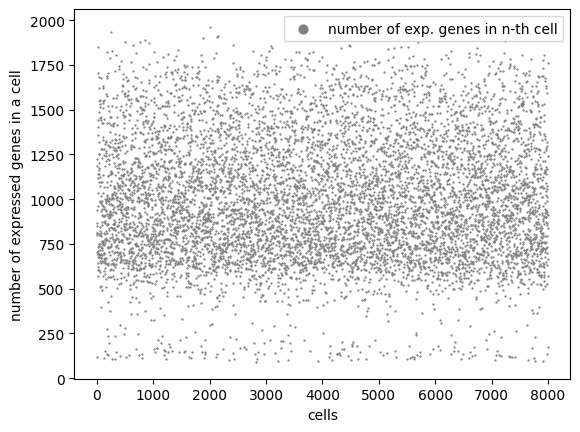

In [96]:
# 2. a - cell distribution plot
cell_dict = {}
cell_list = []
for i in range(len(homework5_data.index)):
    summation = 0
    genes = homework5_data.values[i]
    for gene in genes:
        if gene != 0:
            summation += 1
    cell_dict[homework5_data.index[i]] = summation
    cell_list.append(summation)



plt.scatter([i  for i in range(len(cell_list))],cell_list[::-1], color ='grey',s = 0.4,label = 'number of exp. genes in n-th cell')
plt.ylabel('number of expressed genes in a cell')
plt.xlabel('cells')
plt.rcParams["legend.markerscale"] = 10
plt.rcParams["legend.handlelength"] = 2
plt.rcParams["legend.handleheight"] = 0.7
plt.legend()

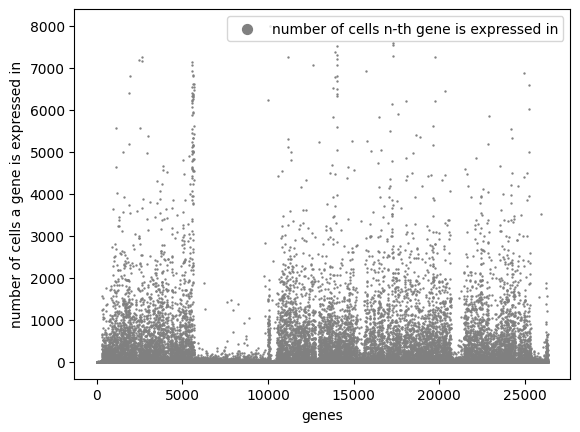

In [97]:
# 2. a - gene distribution plot
gene_dict = {}
gene_list = []
for i in range(len(homework5_data.columns)):
    summation = 0
    cells = transposed_h5_data[i]
    for cell in cells:
        if cell != 0:
            summation += 1
    gene_dict[homework5_data.columns[i]] = summation
    gene_list.append(summation)
plt.scatter([i  for i in range(len(gene_list))],gene_list[::-1], color ='grey',s = 0.5,label = 'number of cells n-th gene is expressed in')
plt.ylabel('number of cells a gene is expressed in')
plt.xlabel('genes')
plt.legend(loc = "upper right")

In [115]:
# 2. b filtering before normalization
cells_to_keep  = [elt[0] for elt in sorted(cell_dict.items(), key=lambda x: x[1],reverse=True)[0:7000]]
genes_to_keep = [elt[0] for elt in sorted(gene_dict.items(), key=lambda x: x[1],reverse=True)[0:5000]]

def flt(
    count_matrix: pd.DataFrame,
    cell_columns: list,
    gene_columns: list,
) -> pd.DataFrame:
    
    original_indices = list(count_matrix.index)
    original_columns = list(count_matrix.columns)
    original_matrix = count_matrix.values
    keep_indices= []
    for i in range(len(original_matrix)):
        if original_indices[i] in cell_columns:
            keep_indices.append(i)
            cell_columns.pop(cell_columns.index(original_indices[i]))

    transposed_matrix = original_matrix.transpose()
    keep_columns = []
    for i in range(len(transposed_matrix)):
        if original_columns[i] in gene_columns:
            keep_columns.append(i)
            gene_columns.pop(gene_columns.index(original_columns[i]))

    # Get new indexes
    new_indices = []
    for i in keep_indices:
        new_indices.append(original_indices[i])
    # Get new columns     
    new_columns = []
    for i in keep_columns:
        new_columns.append(original_columns[i])

    new_matrix = []
    for i in keep_indices:
        row = original_matrix[i]
        new_row = []
        for j in keep_columns:
            new_row.append(row[j])
        new_matrix.append(new_row)

    return pd.DataFrame(index = new_indices, columns = new_columns, data = new_matrix)

In [116]:
homework5_data_filtered = flt(homework5_data, cells_to_keep, genes_to_keep)

In [112]:
# 2. b Normalization
import math
def normalize_expressions(expression_data: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize expressions by applying natural log-transformation with pseudo count 1,
    and scaling expressions of each sample to sum up to 10000.

    Parameters
    ----------
    expression_data: pd.DataFrame
        Expression matrix with cells as rows and genes as columns.

    Returns
    -------
    normalized_data: pd.DataFrame
        Normalized expression matrix with cells as rows and genes as columns.
        Matrix should have the same shape as the input matrix.
        Matrix should have the same index and column labels as the input matrix.
        Order of rows and columns should remain the same.
        Values in the matrix should be positive or zero.
    """
    original_indices = list(expression_data.index)
    original_columns = list(expression_data.columns)
    original_matrix = expression_data.values


    for i in range(len(original_matrix)):
        cell = original_matrix[i]
        for j in range(len(cell)):
            original_matrix[i][j] = math.log(original_matrix[i][j] + 1)
        vsota = sum(original_matrix[i])
        for j in range(len(cell)):
            original_matrix[i][j] /= vsota
        for j in range(len(cell)):
            original_matrix[i][j] *= 10000
    return pd.DataFrame(index = original_indices, columns = original_columns, data = original_matrix,)


In [117]:
homework5_data_normalized = normalize_expressions(homework5_data_filtered)

In [118]:
# 2. c differential analysis
import scipy,statsmodels.stats.multitest

healthy_cells = []
covid_infected_cells = []
for i in range(len(homework5_data_normalized.index)):
    element = homework5_data_normalized.index[i]
    if element[0:5] == "covid":
        covid_infected_cells.append(homework5_data_normalized.values[i])
    else:
        healthy_cells.append(homework5_data_normalized.values[i])


In [120]:
# calculating p values        
corrected_p_values = statsmodels.stats.multitest.fdrcorrection(scipy.stats.ttest_ind(healthy_cells,covid_infected_cells).pvalue)
final_p_values = []
for elt in corrected_p_values[1]:
    if elt == 0:
        final_p_values.append(elt)
    else:
        final_p_values.append(- math.log10(elt))   

In [119]:
# calculating p values        
covid_infected_trsp = np.array(covid_infected_cells).transpose()
healthy_trsp = np.array(healthy_cells).transpose()
FC = []
for i in range(len(healthy_trsp)):
    FC.append(math.log2((sum(covid_infected_trsp[i]) / len(covid_infected_trsp[i])) / (sum(healthy_trsp[i]) / len(healthy_trsp[i]))))

In [149]:
pairsUP = {}
pairsDOWN = {}
important_genes = []
for i in range(len(FC)):
    if FC[i] <= -2 and final_p_values[i] >= 50:
        pairsDOWN[FC[i]] = final_p_values[i]
        important_genes.append(i)
    if FC[i] >= 2 and final_p_values[i] >= 50:
        pairsUP[FC[i]] = final_p_values[i]
        important_genes.append(i)

Text(0.5, 1.0, 'Differential analysis volcano plot')

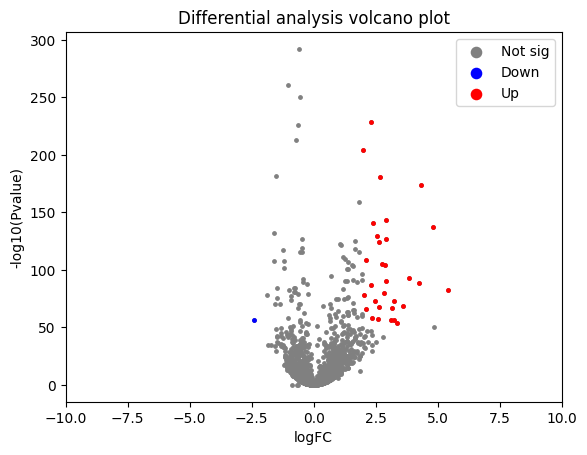

In [137]:
plt.scatter(FC,final_p_values, s =6, color = "grey", label = "Not sig")
plt.scatter(list(pairsDOWN.keys()),list(pairsDOWN.values()), s =6, color = "blue", label = "Down")
plt.scatter(list(pairsUP.keys()),list(pairsUP.values()), s =6, color = "red", label = "Up")

plt.xlim(-10,10)
plt.xlabel("logFC")
plt.ylabel("-log10(Pvalue)")
plt.rcParams["legend.markerscale"] = 3
plt.rcParams["legend.handlelength"] = 2
plt.rcParams["legend.handleheight"] = 0.7
plt.legend()
plt.title("Differential analysis volcano plot")

In [155]:
# finding important genes:
gene_names = []
for elt in important_genes:
    gene_names.append(homework5_data_normalized.columns[elt])


In [172]:
diff_expressed_genes = ['ACSL1',
 'AQP9',
 'C19orf59',
 'CCR1',
 'CCR2',
 'CD163',
 'CES1',
 'CKAP4',
 'CLU',
 'CR1',
 'CYP1B1',
 'DYSF',
 'FCGR1A',
 'FCGR1B',
 'FPR1',
 'IFI27',
 'IFI44',
 'IFI44L',
 'IFI6',
 'IFIT1',
 'IFIT3',
 'IGLC3',
 'MX1',
 'OAS3',
 'PLBD1',
 'RNASE2',
 'RSAD2',
 'S100A12',
 'S100A8',
 'S100A9',
 'SH2D1B',
 'SIGLEC1',
 'SOCS3']

In [191]:

def hypergeometric_pval(N: int, n: int, K: int, k: int) -> float:
    """
    Calculate the p-value using the following hypergeometric distribution.

    Parameters
    ----------
    N: int
        Total number of genes in the study (gene expression matrix)
    n: int
        Number of genes in your proposed gene set (e.g. from differential expression)
    K: int
        Number of genes in an annotated gene set (e.g. GO gene set)
    k: int
        Number of genes in both annotated and proposed geneset

    Returns
    -------
    p_value: float
        p-value from hypergeometric distribution of finding such or
        more extreme match at random
    """
    v1 = math.comb(K,k)


    return (math.comb(K, k) * math.comb(N - K, n - k)) / math.comb(N, n)

In [189]:
N = num_genes  
n = len(diff_expressed_genes)
import json
  
# Opening JSON file
f = open('data/GO_genesets.json')
  
# returns JSON object as 
# a dictionary
go_gene_data = json.load(f)
keys = go_gene_data.keys()  

# Closing file
f.close()

In [170]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [204]:
p_values = {}
p_sez = []
for key in go_gene_data:
    go_gene_list = go_gene_data[key]['genes']
    K = len(go_gene_list)
    k = len(intersection(go_gene_list, diff_expressed_genes))
    p_val =  hypergeometric_pval(N,n,K,k)
    p_sez.append(p_val)
    p_values[go_gene_data[key]['description']] = p_val

In [205]:
p_sez = statsmodels.stats.multitest.fdrcorrection(p_sez)[1]

In [206]:
for elt in range(len(p_sez)):
    key = list(p_values.keys())[elt]
    p_values[key] = p_sez[elt]

In [ ]:
description = sorted(p_values.items(), key=lambda x: x[1],reverse=True)[0]

In [ ]:
description